# Problem Set 1 (110 points) 

## Important information
We provide signatures of the functions that you have to implement. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

Read [homework rules](https://nbviewer.jupyter.org/github/oseledets/nla2018/blob/master/hw.pdf) carefully. <font color='red'>If you do not follow it you will likely be penalized.</font>

# Problem 1 (Python demo) 40 pts

## Data preparation (10 pts)

* First of all download $\verb|.wav|$ file with starcraft sound from [here](https://github.com/oseledets/nla2018/tree/master/psets). Load it in python and play using the following functions:

In [1]:
from scipy.linalg import toeplitz
import numpy as np
import math
import sys
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib notebook

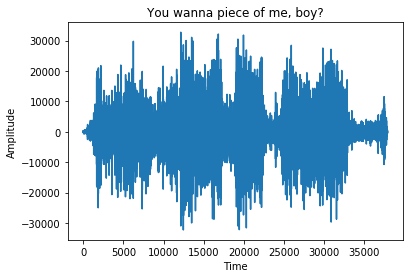

In [2]:
# reading
rate, audio = wav.read("TMaRdy00.wav")

# plotting
plt.plot(audio)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("You wanna piece of me, boy?")
plt.show()

# playing
Audio(audio, rate=rate)

Our next goal is to process this signal by multiplying it by a special type of matrix (convolution operation) that will smooth the signal. 

* (5 pts) Before processing this file let us estimate what size of matrix we can afford. Let $N$ be the size of the signal. Estimate analytically memory in megabytes required to store dense square matrix of size $N\times N$ to fit in your operation memory and print this number. Cut the signal so that you will not have swap (overflow of the operation memory). **Note:** Cut the signal by taking every p-th number in array: ```signal[::p]```. 

In [3]:
N = np.array([audio[::p+1] for p in range(audio.size)]).size
print(N * N * sys.getsizeof(np.int16()) /1024 /1024, 'megabytes') 

35594.0 megabytes


* (5 pts) Write a function 
```python
def gen_toeplitz(N, alpha):    
    return T
```
that outputs matrix $T$: $$T_{ij} = \sqrt{\frac{\alpha}{\pi}}e^{-\alpha (i-j)^2}, \quad i,j=1,\dots,N$$ as numpy array. <font color='red'> Avoid using loops or lists! </font> The function [np.meshgrid](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.meshgrid.html) will be helpful for this task.
**Note:** matrices that depend only on difference of indices: $T_{ij} \equiv T_{i-j}$ are called **Toeplitz**. Toeplitz matrix-by-vector multiplication is **convolution** since it can be written as $$y_i = \sum_{j=1}^N T_{i-j} x_j.$$ Convolutions can be computed faster than $\mathcal{O}(N^2)$ complexity using Fast Fourier transform (will be covered later in our course, no need to implement it here).

In [4]:
# INPUT: N - integer (positive), alpha - float (positive)
# OUTPUT: T - np.array (shape: NxN)

def gen_toeplitz(N, alpha):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    T = (np.sqrt(alpha/np.pi)) * np.exp(-alpha * (i - j)**2)
    return T

## Convolution (10 pts)

* (5 pts) Write a function ```convolution``` (see below)
that takes the signal you want to convolve and multiply it by Toeplitz matrix T (for matvec operations use @ symbol). 

In [5]:
# INPUT: signal - np.array (shape: Nx1), N - int (positive), alpha - float (positive)
# OUTPUT: convolved_signal - np.array (shape: Nx1)

def convolution(signal, N, alpha):
    convolved_signal = np.dot(gen_toeplitz(N, alpha), signal)
    return convolved_signal

* (3 pts) Plot the first $100$ points of the result and the first $100$ points of your signal on the same figure. Do the same plots for $\alpha = \frac{1}{5}$, $\alpha = \frac{1}{100}$ using ```plt.subplots``` in matplotlib. Each subplot should contain first $100$ points of initial and convolved signals for some $\alpha$. Make sure that you got results that look like smoothed initial signal.

* (2 pts) Play the resulting signal. In order to do so you should also scale the frequency (rate), which is one of the inputs in `Audio`.  
Note that you cannot play a signal which is too small.

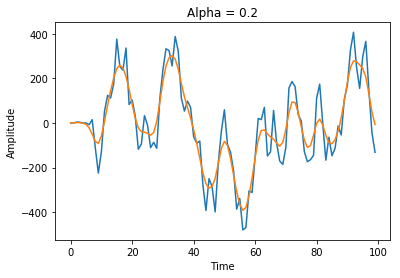

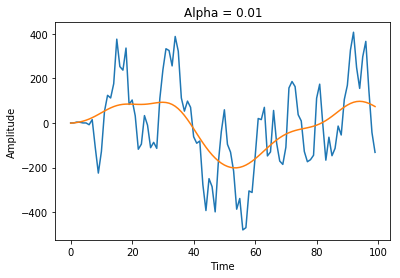

In [6]:
N = 100
signal = audio[:N]
for alpha in [0.2, 0.01]:
    convolved_signal = convolution(signal, N, alpha)
    f, ax = plt.subplots()
    ax.plot(signal)
    ax.plot(convolved_signal)
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time")
    ax.set_title("Alpha = " + str(alpha))
Audio(convolved_signal, rate=rate * alpha)

## Deconvolution (20 pts)

Given a convolved signal $y$ and an initial signal $x$ our goal now is to recover $x$ by solving the system
$$
    y = Tx.
$$
To do so we will run iterative process
$$
    x_{k+1} = x_{k} - \tau_k (Tx_k - y), \quad k=1,2,\dots
$$
starting from zero vector $x_0$. There are different ways how to define parameters $\tau_k$.
Different choices lead to different methods (e.g. Richardson iteration, Chebyshev iteration, etc.).
This topic will be covered in details later in our course.

To get some intuition why this process converges to the solution of $Tx=y$, we can consider the following. Let us note that if $x_k$ converges to some limit $x$, then so does $x_{k+1}$. Taking $k\to \infty$ we arrive at $x = x - \tau (Tx -  y)$ and hence $x$ is the solution of $Tx = y$. 

Another important point is that iterative process requires only matrix-vector porducts $Tx_k$ on each iteration instead of the whole matrix. In this problem we, however, work with the full matrix, but keep in mind, that convolution can be done efficiently without storing the whole matrix.

* (5 pts) For each $k$ choose paremeter $\tau_k$ such that the residual $r_{k+1}=Tx_{k+1} - y$ is minimal possible (*line search* with search direction $r_k$):
$$
    \|Tx_{k+1} - y\|_2 \to \min_{\tau_k}
$$
found analytically. The answer to this bullet is a derivation of $\tau_k$. The parameter $\tau_k$ should be expressed in terms of residuals $r_k = T x_k - y$.

Solution 

Substituting $x_{k+1}=x_k-\tau_k(Tx_k-y)$ into equation $r_{k+1}$:

$$r_{k+1}=Tx_{k+1}-y=Tx_k-T\tau_k(Tx_k-y)-y = (Tx_k-y)-T\tau_k(Tx_k-y)  = (Tx_k-y)(I-\tau_kT)=r_k(I-\tau_kT)$$
$$\tau_k=\arg\min_{\tau_k}\|r_{k+1}\|_2=\arg\min_{\tau_k}\|r_k(I-\tau_kT)\|_2=\arg\min_{\tau_k}\|r_k(I-\tau_kT)\|_2^2$$
$$\frac{\partial\|r_k(I-\tau_kT)\|_2^2}{\partial\tau_k}=\frac{\partial\|r_k-\tau_kTr_k\|_2^2}{\partial\tau_k}=2(r_k-\tau_kTr_k)^T(-Tr_k)=2(\tau_kr_k^TT^TTr_k-r_k^TTr_k)=0$$
$$\implies \tau_k=\frac{r_k^TTr_k}{r_k^TT^TTr_k}$$

* (10 pts) Write a function ```iterative```
that outputs accuracy –– a numpy array of relative errors $\big\{\frac{\|x_{k+1} - x\|_2}{\|x\|_2}\big\}$ after ```num_iter``` iterations using $\tau_k$ from the previous task. **Note:** The only loop you are allowed to use here is a loop for $k$.

In [7]:
# INPUT:  N - int (positive), alpha - float (positive), num_iter - integer (positive), 
#  y - np.array (shape: Nx1, convolved signal), s - np.array (shape: Nx1, original signal)
# OUTPUT: rel_error - np.array size (num_iter x 1)
from numpy.linalg import multi_dot

def iterative(N, num_iter, y, s, alpha):
    T = gen_toeplitz(N, alpha)
    x = np.zeros(N)
    rel_error = np.zeros(num_iter)
    for k in range(0,num_iter):
        r = np.dot(T, x) - y
        tau = (multi_dot([np.transpose(r), T, r])/multi_dot([np.transpose(r), np.transpose(T), T, r]))
        x = x - tau * r
        rel_error[k] = np.linalg.norm(x - s, ord = 2)/np.linalg.norm(s, ord = 2) 
    return rel_error

* (2 pts) Set ```num_iter=1000```, ```x=s[::20]``` and do a convergence plot for $\alpha = \frac{1}{2}$ and $\alpha = \frac{1}{5}$.

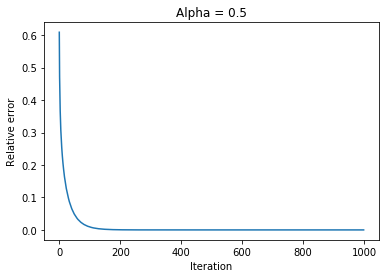

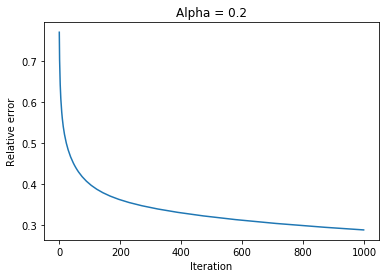

In [8]:
num_iter = 1000
x = audio[::20]
N = x.size
for alpha in [0.5, 0.2]:
    y = convolution(x, N, alpha)
    plt.plot(iterative(N, num_iter, y, x, alpha))
    plt.title("Alpha = " + str(alpha))
    plt.xlabel('Iteration')
    plt.ylabel('Relative error')
    plt.show()

* (3 pts) Set ```x=s[::20]```, ```num_iter=1000``` and $\alpha=\frac{1}{5}$. Explain what happens with the convergence if you add small random noise of amplitude $10^{-3}\max(x)$  to $y$. The answer to this question should be an explanation supported by plots and/or tables.

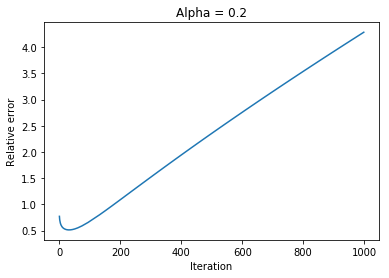

Signals’ similarity ratio:  0.0


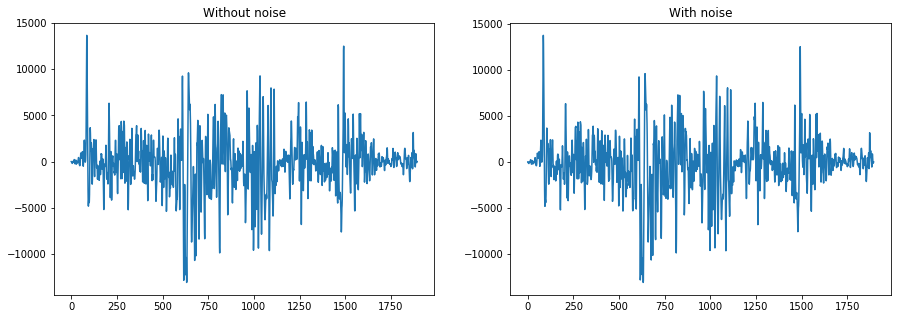

In [9]:
import difflib
num_iter = 1000
x = audio[::20]
N = len(x)
alpha = 0.2

y = convolution(x, N, alpha)
noise = np.random.normal(0,1,N) * 1e-3 * np.max(x)
err = iterative(N,num_iter, y + noise, x, alpha)
plt.plot(err)

plt.title("Alpha = " + str(alpha))
plt.xlabel('Iteration')
plt.ylabel('Relative error')
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(y)
ax1.set_title('Without noise')
ax2.plot(y + noise)
ax2.set_title('With noise')

sm = difflib.SequenceMatcher(None,y,y+noise)

print ('Signals’ similarity ratio: ', sm.ratio())

We can't convlute and then deconvolute totally different signal. But as we can see in the plots they are almost the same on the first look.

# Problem 2 (Theoretical tasks)  45 pts
_1._
- (5 pts) Prove that $\| U A \|_F = \| A U \|_F = \| A \|_F$ for any unitary matrix $U$.

$$\| U A \|_F = \sqrt{tr((UA)^* UA)} = \sqrt{tr(A^*U^*UA)} =\sqrt{tr(A^*IA)}=\sqrt{tr(A^*A)}=\|A \|_F\\ = \| A U \|_F = \sqrt{tr((AU)^* AU)} = \sqrt{tr(U^*A^*AU)}=\sqrt{tr(UU^*A^*A)}=\sqrt{tr(IA^*A)}=\sqrt{tr(A^*A)}=\|A \|_F$$

- (5 pts) Prove that $\| Ux \|_2 = \| x \|_2$ for any $x$ iff $U$ is unitary.

$$\| Ux \|_2 = \sqrt{(Ux)^*Ux} = \sqrt{x^*U^*Ux} = \sqrt{x^*Ix} =\sqrt{x^*x}= \| x \|_2$$

- (5 pts) Prove that $\| U A \|_2 = \| A U \|_2 = \| A \|_2$ for any unitary $U$.

$$\| UA\|_2 = \sup_{\|x\|_2\neq0}\frac{\|UAx\|_2}{\|x\|_2} = \sup_{\|x\|_2=1}\|UAx\|_2 = \sup_{\|x\|_2=1}\|Ax\|_2=\|A\|_2\\ = 
\| AU\|_2 = \sup_{\|x\|_2\neq0}\frac{\|AUx\|_2}{\|x\|_2}=\sup_{\|x\|_2=1}\|AUx\|_2=\sup_{\|Ux\|_2=1}\|AUx\|_2=\sup_{\|y\|_2=1}\|Ay\|_2=\|A\|_2$$
  
_2._
- (5 pts) Using the results from the previous subproblem, prove that $\| A \|_F \le \sqrt{\mathrm{rank}(A)} \| A \|_2$. _Hint:_ SVD will help you.

$$\|A\|_F=\sqrt{tr(AA^*)}=\sqrt{tr(U\Sigma V^*(U\Sigma V^*)^*)}=\sqrt{tr(U\Sigma V^*V\Sigma^* U^*)}=
\sqrt{tr(U\Sigma\Sigma^*U^*)}=\sqrt{tr(U^*U\Sigma\Sigma^*)}=\sqrt{tr(\Sigma\Sigma^*)}\\
\|A\|_2=\sup_{\|x\|_2=1}\|Ax\|_2=\sup_{\|x\|_2=1}\|U\Sigma V^*x\|_2=\sup_{\|x\|_2=1}\|\Sigma V^*x\|_2=\sup_{\|x\|_2=1}\|U\Sigma V^*x\|_2=\sup_{\|V^*x\|_2=1}\|\Sigma V^*x\|_2=\\
\qquad=\sup_{\|y\|_2=1}\|\Sigma y\|_2=\sup_{\|y\|_2=1}\sqrt{tr(\Sigma y(\Sigma y)^*)}=\sup_{\|y\|_2=1}\sqrt{tr(\Sigma yy^*\Sigma^*)}=\sup_{\|y\|_2=1}\sqrt{tr((\Sigma yy^*\Sigma^*)^*)}=\sup_{\|y\|_2=1}\sqrt{tr(\Sigma y^*y\Sigma^*)}=\\
\qquad=\sup_{\|y\|_2=1}\sqrt{tr(\Sigma \|y\|_2\Sigma^*)}=\sigma_{max}\\
\|A\|_F=\sqrt{tr(\Sigma\Sigma^*)}=\sqrt{\sum_{k=1}^{rank(A)}\sigma_k^2}\leq\sqrt{\sum_{k=1}^{rank(A)}\sigma_{max}^2}=\sigma_{max}\sqrt{rank(A)}=\|A\|_2\sqrt{rank(A)}$$

- (5 pts) Show that for any $m, n$ and $k \le \min(m, n)$ there exists $A \in \mathbb{R}^{m \times n}: \mathrm{rank}(A) = k$, such that $\| A \|_F = \sqrt{\mathrm{rank}(A)} \| A \|_2$. In other words, show that the previous inequality is not strict.

If all singular values of matrix $A$ are equal, then they equal to $\sigma_{max}$, then $$\|A\|_F=\sqrt{\sum_{k=1}^{rank(A)}\sigma_k^2}=\sigma_{max}\sqrt{rank(A)}=\|A\|_2\sqrt{rank(A)}$$

- (5 pts) Prove that if $\mathrm{rank}(A) = 1$, then $\| A \|_F  = \| A \|_2$.

$$\|A\|_F=\sqrt{tr(\Sigma\Sigma^*)}=\sqrt{\sum_{k=1}^{rank(A)}\sigma_k^2}\geq\sigma_{max}=\|A\|_2$$
Then $\|A\|_2\leq\|A\|_F\leq\sqrt{rank(A)}\|A\|_2$, and if $rank(A)=1$, then $\|A\|_2\leq\|A\|_F\leq\|A\|_2$, or $\|A\|_F=\|A\|_2$

- (5 pts) Prove that $\| A B \|_F \le \| A \|_2 \| B \|_F$.

Since $\|A\|_p=\sup_{\|x\|=1}\frac{\|Ax\|_p}{\|x\|_p}$, then $\|A\|_p\|x\|_p\geq\|Ax\|_p$.

Let $B=(b_1,\ldots,b_n)$, where the $b_i$'s are the columns of $B$. Then
$$\| A B \|_F^2=\sum_{i=1}^n\| A b_i \|_2^2\leq\|A\|_2^2\sum_{i=1}^n\|b_i\|_2^2=\|A\|_2^2\|B\|_F^2$$
$$\| A B \|_F\leq\|A\|_2\|B\|_F$$

_3._    
* (3 pts) Differentiate with respect to $A$ the function
$$
f(A) = \mathrm{sin}(x^\top A B C D x),
$$
where $x$ is a vector and $A, B, C, D$ are square matrices.

Lets use $\frac{\partial( a^TXb)}{\partial X}=ab^T$ 

For solving $( a=x, \quad b=BCDx,\quad X=A)$, and after replacement $u=x^TABCDx$. We get:

$$\frac{\partial (\sin(x^TABCDx))}{\partial X}=\frac{\partial\sin u}{\partial u}\frac{\partial x^TABCDx}{\partial A}=\cos(x^TABCDx)x(BCDx)^T=\cos(x^TABCDx)xx^TD^TC^TB^T $$

* (7 pts) Differentiate with respect to $y, A, X$ the function
$$f(y, A, X) = \mathrm{tr}(\mathrm{diag}(y) A X),$$
where $y \in \mathbb{R}^n$ and $A, X \in \mathbb{R}^{n \times n}$. Here 

$$
\mathrm{diag}(y)_{i, j} = 
    \begin{cases}
      y_i, & \text{if}\ i = j \\
      0, & \text{otherwise}
    \end{cases}
$$

# Problem 3 (Strassen algorithm) 15 pts

_1._ (3 pts) Implement the naive algorithm for squared matrix multiplication with explicit “for” cycles.

In [10]:
from numba import jit

@jit(nopython=True)
def naive_multiplication(A, B):
    """
    Implement naive matrix multiplication with explicit for cycles
    
    Parameters: Matrices A, B
    
    Returns: Matrix C = AB
    """
    C = np.zeros((A.shape[0], B.shape[1]))
    for i in range(len(A)):
        for j in range(len(B[0])):
            for k in range(len(B)):
                C[i][j] += A[i][k]*B[k][j]
    return np.array(C)

_2._ (7 pts) Implement the Strassen algorithm.

In [11]:
@jit(nopython=True)
def strassen(A, B):
    """
    Implement Strassen algorithm for matrix multiplication 
    
    Parameters: Matrices A, B
    
    Returns: Matrix C = AB
    """
    def split(matrix):
        length = len(matrix)
        if(length % 2 is not 0):
            stack = []
            for x in range(length + 1):
                stack.append(float(0))
            length += 1
            matrix = np.insert(matrix, len(matrix), values=0, axis=1)
            matrix = np.vstack([matrix, stack])
        d = (length // 2)
        matrix = matrix.reshape(length, length)
        completedPartition = [matrix[:d, :d], matrix[d:, :d], matrix[:d, d:], matrix[d:, d:]]
        return completedPartition
    
    if A.shape[0] == 1:
        d = [[0]]
        d[0][0] = A[0][0] * B[0][0]
        return np.array(d)
    else:
        #split matrices into quarters
        a11, a12, a21, a22 = split(A)
        b11, b12, b21, b22 = split(B)
        p1 = strassen(a11 + a22, b11 + b22)  # p1 = (a11 + a22) * (b11 + b22)
        p2 = strassen(a21 + a22, b11)        # p2 = (a21 + a22) * b11
        p3 = strassen(a11, b12 - b22)        # p3 = a11 * (b12 - b22)
        p4 = strassen(a22, b21 - b11)        # p4 = a22 * (b21 - b11)
        p5 = strassen(a11 + a12, b22)        # p5 = (a11 + a12) * b22
        p6 = strassen(a21 - a11, b11 + b12)  # p6 = (a21 - a11) * (b11 + b12)
        p7 = strassen(a12 - a22, b21 + b22)  # p7 = (a12 - a22) * (b21 + b22)
        c11 = p1 + p4 - p5 + p7  # c11 = p1 + p4 - p5 + p7
        c12 = p3 + p5            # c12 = p3 + p5
        c21 = p2 + p4            # c21 = p2 + p4
        c22 = p1 + p3 - p2 + p6  # c22 = p1 + p3 - p2 + p6
        c = np.vstack((np.hstack((c11, c12)), np.hstack((c21, c22)))) 
        return np.array(c)

In [12]:
a = np.matrix(np.random.randint(10, size=(2,2)))
b = np.matrix(np.random.randint(10, size=(2,2)))
assert naive_multiplication(a, b).all() == np.dot(a, b).all()
assert strassen(a, b).all() == np.dot(a, b).all()
# Yeah, it actually works :) 

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUse of unsupported NumPy function 'numpy.insert' or unsupported use of the function.
[1m
File "<ipython-input-11-3314a9a47568>", line 17:[0m
[1m    def split(matrix):
        <source elided>
            length += 1
[1m            matrix = np.insert(matrix, len(matrix), values=0, axis=1)
[0m            [1m^[0m[0m
[0m
[0m[1m[1] During: typing of get attribute at <ipython-input-11-3314a9a47568> (17)[0m
[1m
File "<ipython-input-11-3314a9a47568>", line 17:[0m
[1m    def split(matrix):
        <source elided>
            length += 1
[1m            matrix = np.insert(matrix, len(matrix), values=0, axis=1)
[0m            [1m^[0m[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


_3._ (5 pts) Compare three approaches: naive multiplication, Strassen algorithm and standard NumPy function. 
Provide a plot in log-scale of dependence between the matrix size and the runtime of multiplication. You will have three lines, do not forget to add legend, axis labels and other attributes (see our [requirements](https://nbviewer.jupyter.org/github/oseledets/nla2018/blob/master/hw.pdf))  
Consider the matrix size in the range of 100 to 700 with step 100, e.g. $n=100, 200,\ldots, 700$. 
Justify the results theoretically (e.g., use the known formulas for total multiplication complexity of naive and Strassen algorithms).

For Naive its $O(n^3)$, for Strassen its $O(n^{2.807})$

| Naive   |      Strassen      | Size |
|----------|:-------------:|:-------------:|
| 1000000 |  411149.721105 |100 |
| 8000000 |    2877340.09694   | 200 |
| 27000000 | 8980062.55563 |300 |
| ... | ... |... |
| 343000000 | 96870200.4305 | 700 |

In [ ]:
import time
def mes(f, a, b):
    start = time.time()
    f(a,b)
    end = time.time()
    return (end - start)

naive_times = []
strassen_times = []
numpy_times = []

sizes = list(range(100, 800, 100))
for i in sizes:
    a = np.matrix(np.random.randint(5, size=(i,i)))
    b = np.matrix(np.random.randint(5, size=(i,i)))
    
    naive_time = mes(naive_multiplication, a, b)
    print ("Naive matrix multiplication, time = {0}, size = {1}".format(naive_time, i))
    
    strassen_time = mes(strassen, a, b)
    print ("Strassen matrix multiplication, time = {0}, size = {1}".format(strassen_time, i))
    
    numpy_time = mes(np.dot, a, b)
    print ("Numpy matrix multiplication, time = {0}, size = {1}".format(numpy_time, i))
    
    naive_times.append(naive_time)
    strassen_times.append(strassen_time)
    numpy_times.append(numpy_time)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))

ax1.plot(sizes,naive_times)
ax1.set_xlabel('Size')
ax1.set_ylabel('Time')
ax1.set_title('Naive')

ax2.plot(sizes,strassen_times)
ax2.set_xlabel('Size')
ax2.set_ylabel('Time')
ax2.set_title('Strassen')

ax3.plot(sizes,numpy_times)
ax3.set_xlabel('Size')
ax3.set_ylabel('Time')
ax3.set_title('Numpy')

# Problem 4 (SVD) 10 pts
In this assignment you are supposed to study how SVD could be used in image compression.

_1._ (2 pts) Compute the singular values of some predownloaded image (via the code provided below) and plot them. Do not forget to use logarithmic scale.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests
import numpy as np


url = 'https://pbs.twimg.com/profile_images/1658625695/my_photo_400x400.jpg'  # Ivan
url = 'https://i.chzbgr.com/full/5536320768/h88BAB406/' # Insight
# url = '' # your favorite picture, please!

face_raw = Image.open(requests.get(url, stream=True).raw)
face = np.array(face_raw).astype(np.uint8)

plt.imshow(face_raw)
plt.xticks(())
plt.yticks(())
plt.title('Original Picture')
plt.show()

In [ ]:
u, s, vh = np.linalg.svd(face,full_matrices=False)
plt.plot(np.log(s/s[0,:]))

_2._ (3 pts) Complete a function ```compress```, that performs SVD and truncates it (using $k$ singular values/vectors). See the prototype below. 

Note, that in colourful case you have to split your image to channels and work with matrices corresponding to different channels separately.

Plot approximate reconstructed image $M_\varepsilon$ of your favorite image such that $rank(M_\varepsilon) = 5, 20, 50$ using ```plt.subplots```.

In [ ]:
def compress(image, k):
    """
    Perform svd decomposition and truncate it (using k singular values/vectors)
    
    Parameters: 
        image (np.array):        input image (probably, colourful)
        
        k (int):                 approximation rank
        
    --------
    Returns:
      reconst_matrix (np.array): reconstructed matrix (tensor in colourful case)
      
      s (np.array):              array of singular values 
    """
    image2 = image.copy()
    
    Rf = image2[:,:,0]
    Gf = image2[:,:,1]
    Bf = image2[:,:,2]
    
    Ru, Rs, Rvh = np.linalg.svd(Rf, full_matrices=False)
    Gu, Gs, Gvh = np.linalg.svd(Gf, full_matrices=False)
    Bu, Bs, Bvh = np.linalg.svd(Bf, full_matrices=False)
    
    Rs = Rs[:k]
    Gs = Gs[:k]
    Bs = Bs[:k]
    
    reduced_im = np.zeros((image.shape),np.uint8)
    
    Red   = Ru[:,:k] @ np.diag(Rs) @ Rvh[:k,:]
    Green = Gu[:,:k] @ np.diag(Gs) @ Gvh[:k,:]
    Blue  = Bu[:,:k] @ np.diag(Bs) @ Bvh[:k,:]
    
    reduced_im[:,:,0] = Red 
    reduced_im[:,:,1] = Green
    reduced_im[:,:,2] = Blue
    
    s = np.zeros((len(Gs),3))
    s[:,0] = Rs
    s[:,1] = Gs
    s[:,2] = Bs
    return reduced_im.copy(), s

In [ ]:
plt.figure(figsize=(18,12))
for i,k in enumerate([5,20,50]):
    plt.subplot(3,3,i+1)
    im,s = compress(face,k)
    plt.imshow(Image.fromarray(im,"RGB"))
    plt.xticks(())
    plt.yticks(())
    plt.title("Rank M ={}".format(k))

_3._ (3 pts) Plot the following two figures for your favorite picture
* How relative error of approximation depends on the rank of approximation?
* How compression rate in terms of storing information ((singular vectors + singular numbers) / total size of image) depends on the rank of approximation?

_4._ (2 pts) Consider the following two pictures. Compute their approximations (with the same rank, or relative error). What do you see? Explain results.

In [ ]:
url1 = 'http://sk.ru/resized-image.ashx/__size/550x0/__key/communityserver-blogs-components-weblogfiles/00-00-00-60-11/skoltech1.jpg'
url2 = 'http://www.simpsoncrazy.com/content/characters/poster/bottom-right.jpg'
image_raw1 = Image.open(requests.get(url1, stream=True).raw)
image_raw2 = Image.open(requests.get(url2, stream=True).raw)

image1 = np.array(image_raw1).astype(np.uint8)
image2 = np.array(image_raw2).astype(np.uint8)

plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.imshow(image_raw1)
plt.title('One Picture')
plt.xticks(())
plt.yticks(())

plt.subplot(1,2,2)
plt.imshow(image_raw2)
plt.title('Another Picture')
plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
image1_comp, _ = compress(image1,20)
image2_comp, _ = compress(image2,100)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(Image.fromarray(image1_comp,"RGB"))
plt.xticks(())
plt.yticks(())
plt.subplot(1,2,2)
plt.imshow(Image.fromarray(image2_comp,"RGB"))
plt.xticks(())
plt.yticks(())
plt.show()

# Problem 5 (Bonus)

1. The norm is called absolute if $\|x\|=\| \lvert x \lvert \|$ holds for any vector $x$, where $x=(x_1,\dots,x_n)^T$ and $\lvert x \lvert = (\lvert x_1 \lvert,\dots, \lvert x_n \lvert)^T$. Give an example of a norm which is not absolute.

2. Write a function ```ranks_HOSVD(A, eps)```
that calculates Tucker ranks of a d-dimensional tensor $A$ using High-Order SVD (HOSVD) algorithm, where ```eps``` is the relative accuracy in the Frobenius norm between the approximated and the initial tensors. Details can be found [here](http://ca.sandia.gov/~tgkolda/pubs/pubfiles/TensorReview.pdf) on Figure 4.3.
```python
def ranks_HOSVD(A, eps):
      return r #r should be a tuple of ranks r = (r1, r2, ..., rd)
```